In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, dataset, random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import itertools
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import collections
from PIL import ImageFile
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
classes = 'drive/My Drive/MS-ASL/MSASL_classes.json'
train_json = 'drive/My Drive/MS-ASL/MSASL_train.json'
test_json = 'drive/My Drive/MS-ASL/MSASL_test.json'
val_json = 'drive/My Drive/MS-ASL/MSASL_val.json'
train_videos = 'drive/My Drive/HW4_DATA/videos/train/'
val_videos = 'drive/My Drive/HW4_DATA/videos/val/'
test_videos = 'drive/My Drive/HW4_DATA/videos/test/'

In [ ]:
classes = {'hello' : 0, 'nice' :1, 'teacher':2,  'eat':3 , 'no':4, 'happy':5, 'like':6, 'orange':7, 'want' :8, 'deaf':9}

In [ ]:
def load_data(path,is_test):
  df = pd.read_json(path)
  for value in df['clean_text'].values:
    if value not in classes.keys():
      df.drop(df[df['clean_text']== value].index, inplace = True)
  df['url'] = df['url'].apply(lambda x : 'w' + x.lstrip('https://www.youtube.com'))
  
  return df

In [ ]:
def clean_data(path, df):
  files = [os.path.splitext(f)[0] for f in listdir(path) if isfile(join(path, f))]
  with_ext = [f for f in listdir(path) if isfile(join(path, f))]
  org_values = df['url'].values
  for value in df['url'].values:
    if value not in files:
      df.drop(df[df['url']== value].index, inplace = True) 
  

  for i in range(0, df.shape[0]):
    if df.iloc[i,12] in files:
      index = files.index(df.iloc[i,12])
      df = df.replace(df.iloc[i,12], with_ext[index])
 
  return df

In [ ]:
train_df = load_data(train_json, False)
train_df = clean_data(train_videos, train_df)
val_df = load_data(val_json, False)
val_df = clean_data(val_videos, val_df)
test_df = load_data(test_json, True)
test_df = clean_data(test_videos, test_df)

In [ ]:
def extract_flows(source, dest, df):
  files = [f for f in listdir(source) if isfile(join(source, f))]
  for i in range(0, df.shape[0]):
    start_frame = df.iloc[i][5]
    video = cv2.VideoCapture(source + df.iloc[i][12]) 
    file_path = dest  + df.iloc[i][12] + '_' + df.iloc[i][1]
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    ret, first_frame = video.read()

    first_frame= cv2.resize(first_frame, (224,224), interpolation = cv2.INTER_AREA)
    mask = np.zeros_like(first_frame)
    mask[..., 1] = 255


    prev = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    flows = prev

    for j in range(start_frame+1, start_frame+10):     
      if(ret):
        video.set(cv2.CAP_PROP_POS_FRAMES, j)
        ret, frame = video.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        current = cv2.resize(gray, (224,224), interpolation = cv2.INTER_AREA)
        flow = cv2.calcOpticalFlowFarneback(prev, current, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
        
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        mask[..., 0] = angle * 180 / np.pi / 2
      
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        flow_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
        flows = np.dstack((flows, flow_image))
        prev = current
      else:
        print(df.iloc[i][12], j)
    np.save(file_path, flows)

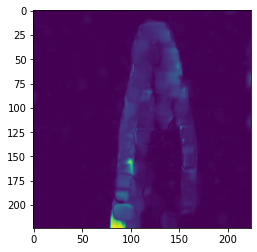

In [ ]:
video = cv2.VideoCapture(train_videos + train_df.iloc[23][12])
start_frame = train_df.iloc[23][5]
video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
ret, first_frame = video.read()
first_frame =  cv2.resize(first_frame, (224,224), interpolation = cv2.INTER_AREA)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255
prev = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
video.set(cv2.CAP_PROP_POS_FRAMES, start_frame+1)
ret, current = video.read()
current = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
current= cv2.resize(current, (224,224), interpolation = cv2.INTER_AREA)

flow = cv2.calcOpticalFlowFarneback(prev, current, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)

magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

mask[..., 0] = angle * 180 / np.pi / 2

mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
flow_image = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(flow_image)

In [ ]:
# extract_flows(train_videos, 'drive/My Drive/flows/train/', train_df)
# extract_flows(val_videos, 'drive/My Drive/flows/val/', val_df)
# extract_flows(test_videos, 'drive/My Drive/flows/test/', test_df)

In [ ]:
class TemporalDataset(datasets.ImageFolder):

  def __init__(self,path,df, classes, transform):
    self.path = path
    self.df = df
    self.transform = transform
    self.classes = classes

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    # if torch.is_tensor(idx):
    #   idx = idx.tolist()

    path =  self.path + self.df.iloc[idx][12] + '_' +  self.df.iloc[idx][1] + ".npy"

    flow = np.load(path)
    flow = np.transpose(flow)
    # print(flow.shape)


    label = self.classes[self.df.iloc[idx][1]]

    return  (flow, label) 

In [ ]:
transform = transforms.Compose([
  
  transforms.ToTensor(),
                         
])



In [ ]:
def getdataloader_sizes(batchsize): 
  train =  TemporalDataset( path = 'drive/My Drive/flows/train/', df = train_df, classes = classes, transform = transform)
  validation = TemporalDataset( path = 'drive/My Drive/flows/val/', df = val_df,  classes = classes, transform = transform)
  test = TemporalDataset( path = 'drive/My Drive/flows/test/', df = test_df,  classes = classes, transform = transform)

  
  all_datasets = {'train' : train, 'validation' : validation, 'test' : test}

  dataloaders = {x: torch.utils.data.DataLoader(all_datasets[x], batch_size=batchsize,
                                               shuffle=True)
                for x in ['train', 'validation' ,'test']}
  dataset_sizes = {x: len(all_datasets[x]) for x in ['train', 'validation','test']}

  class_names = list(classes.keys())
  print(class_names)
  print(dataset_sizes)
  return dataloaders,dataset_sizes,class_names

In [ ]:
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
def plot_graph(plotlist1,plotlist2,ylabel):
   
    plt.xlabel("Training Epochs")
    plt.ylabel(ylabel)
    plt.plot(plotlist1, color="green")
    plt.plot(plotlist2, color="yellow")
    
    plt.gca().legend(('Train', 'Validation'))
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, epoch_number,device,earlystopping):
   
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_acc = 0.0
    best_val_acc = 0.0
    best_test_acc = 0.0
    train_acc_history = list()
    train_loss_history =list()
    val_acc_history = list()
    val_loss_history =list()
    
    counter = 0
    stop =False
    best_loss = None
    
   
    n_epochs_stop = 1
    min_val_loss = np.Inf
    epochs_no_improve = 0
    
    for epoch in range(epoch_number):
        if stop:
          break
        print('Epoch {}/{}'.format(epoch, epoch_number - 1))
        
        # Train and validation for each epoch
        for part in ['train', 'validation']:
            if part == 'train':
                
                model.train()  
            else:
                model.eval()  

            current_loss = 0.0
            current_phase_correct_outputnumber = 0
            # For each phase in datasets are iterated
            for inputs, labels in dataloaders[part]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(part == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Backpropagate and opitimize Training part
                    if part == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                current_loss += loss.item() * inputs.size(0)
                current_phase_correct_outputnumber += torch.sum(preds == labels.data)

            current_loss = current_loss / dataset_sizes[part]
            epoch_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes[part]

            if part == 'validation':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(current_loss)
                if earlystopping:
                  # If the validation loss is at a minimum
                  if current_loss < min_val_loss:
                    # Save the model
                    epochs_no_improve = 0
                    min_val_loss = current_loss

                  else:
                    epochs_no_improve += 1
                    # Check early stopping condition
                    if epochs_no_improve == n_epochs_stop:
                      print('Early stopping!')
                      
                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      print()

                      #Printed best accuracies
                      print('Best train Acc: {:4f}'.format(best_train_acc))
                      print('Best validation Acc: {:4f}'.format(best_val_acc))

                      # load best model weights
                      model.load_state_dict(best_model_wts)
                      #Plot accuracy graph 
                      plot_graph(train_acc_history,val_acc_history,"Accuracy")
                      plot_graph(train_loss_history,val_loss_history,"Loss")
                      
                      return model                  
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(current_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                part, current_loss, epoch_acc))

            # deep copy the model
            if part == 'train' and epoch_acc > best_train_acc:
                  best_train_acc = epoch_acc
                
            if part == 'validation' and epoch_acc > best_val_acc:             
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              
        print() 
    
              
    print('Best train Acc: {:4f}'.format(best_train_acc))
    print('Best validation Acc: {:4f}'.format(best_val_acc))
    
  
    model.load_state_dict(best_model_wts)
   
    plot_graph(train_acc_history,val_acc_history,"Accuracy")
    plot_graph(train_loss_history,val_loss_history,"Loss")
  
    return model

In [ ]:
class TemporalSimpleNet(nn.Module):

  def __init__(self):
    super(TemporalSimpleNet, self).__init__()

    self.conv1 = torch.nn.Conv2d(10, 18, kernel_size = 3, stride = 1, padding = 1)
    self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    
    self.fc1 = torch.nn.Linear(18 * 112 * 112, 64)
    
    self.fc2 = torch.nn.Linear(64, 10)


  
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = x.view(-1, 18 * 112 *112)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return(x)

class TemporalNet(nn.Module):
  def __init__(self):
      super(TemporalNet, self).__init__()
      
      self.conv1 = nn.Conv2d(10, 96, 7, 2)
      self.relu1 = nn.ReLU()
      self.pool1 = nn.MaxPool2d(3, 2)
      self.norm1 = nn.LocalResponseNorm(2)
      self.conv2 = nn.Conv2d(96, 256, 5, 2)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(3, 2)
      self.norm2 = nn.LocalResponseNorm(2)
      self.conv3 = nn.Conv2d(256, 512,3)
      self.relu3 = nn.ReLU()
      self.conv4 = nn.Conv2d(512, 512, 3)
      self.relu4= nn.ReLU()
      self.conv5 = nn.Conv2d(512, 512, 3)           
      self.relu5 = nn.ReLU()
      self.pool3 =nn.MaxPool2d(3, 2)
  

  
      self.l1 = nn.Linear(2048, 4096)
      self.drop1 = nn.Dropout()
      self.l2 = nn.Linear(4096, 2048)
      self.drop2 = nn.Dropout()
      self.l3 =nn.Linear(2048, 10)
        
      
      

  def forward(self, x):
      x = self.conv1(x.float())
      x = self.relu1(x)
      x = self.pool1(x)
      x = self.norm1(x)

      x = self.conv2(x)
      x = self.relu2(x)
      x = self.pool2(x)
      x = self.norm2(x)

      x = self.conv3(x)
      x = self.relu3(x)

      x = self.conv4(x)
      x = self.relu4(x)


      x = self.conv5(x)
      x = self.relu5(x)
      x = self.pool3(x)

      x = x.view(x.size(0), -1)
      x = self.l1(x)
      x = self.drop1(x)
      x = self.l2(x)
      x = self.drop2(x)
      x = self.l3(x)

      return x

net = TemporalNet()
simple_net = TemporalSimpleNet()

['hello', 'nice', 'teacher', 'eat', 'no', 'happy', 'like', 'orange', 'want', 'deaf']
{'train': 378, 'validation': 103, 'test': 92}
Epoch 0/63
train Loss: 33.9242 Acc: 13.4921
validation Loss: 2.4770 Acc: 7.7670

Epoch 1/63
train Loss: 1.9046 Acc: 47.3545
validation Loss: 2.6242 Acc: 7.7670

Epoch 2/63
train Loss: 1.2678 Acc: 72.4868
validation Loss: 2.8641 Acc: 13.5922

Epoch 3/63
train Loss: 0.9057 Acc: 83.0688
validation Loss: 3.0341 Acc: 7.7670

Epoch 4/63
train Loss: 0.6174 Acc: 92.8571
validation Loss: 3.3275 Acc: 15.5340

Epoch 5/63
train Loss: 0.3959 Acc: 97.3545
validation Loss: 3.4500 Acc: 12.6214

Epoch 6/63
train Loss: 0.2669 Acc: 98.4127
validation Loss: 3.6425 Acc: 11.6505

Epoch 7/63
train Loss: 0.1843 Acc: 99.2063
validation Loss: 3.8371 Acc: 11.6505

Epoch 8/63
train Loss: 0.1328 Acc: 99.2063
validation Loss: 3.9911 Acc: 11.6505

Epoch 9/63
train Loss: 0.0975 Acc: 99.7354
validation Loss: 4.0561 Acc: 15.5340

Epoch 10/63
train Loss: 0.0741 Acc: 100.0000
validation Loss:

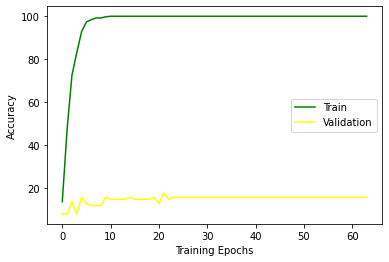

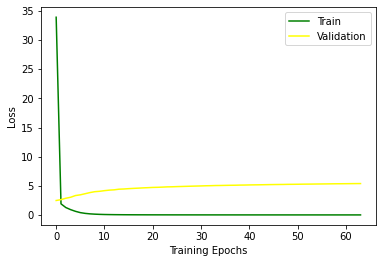

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 

trainingmodel = simple_net




#initializing parameters
learning_rate = 0.001
epoch = 64
batchsize = 64
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trainingmodel.parameters(), lr=learning_rate)
earlystoping = False


dataloaders,dataset_sizes,class_names = getdataloader_sizes(batchsize)


trained_model = train_model(trainingmodel, criterion, optimizer,epoch,device,earlystoping)

In [ ]:
def calculateTestAcc(trained_model,dataloaders,dataset_sizes):
  confusion_matrixx = torch.zeros(10, 10)
  np.set_printoptions(precision=2)
  current_phase_correct_outputnumber = 0

  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        current_phase_correct_outputnumber += torch.sum(preds == classes.data)
          
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrixx[t.long(), p.long()] += 1
   
    test_acc = 100*current_phase_correct_outputnumber.double() / dataset_sizes['test']

    print('Test Acc: {:4f}'.format(test_acc))
    
  plt.figure(figsize = (10,10))
  plot_confusion_matrix(confusion_matrixx,classes=class_names)
  plt.show()

Test Acc: 17.391304


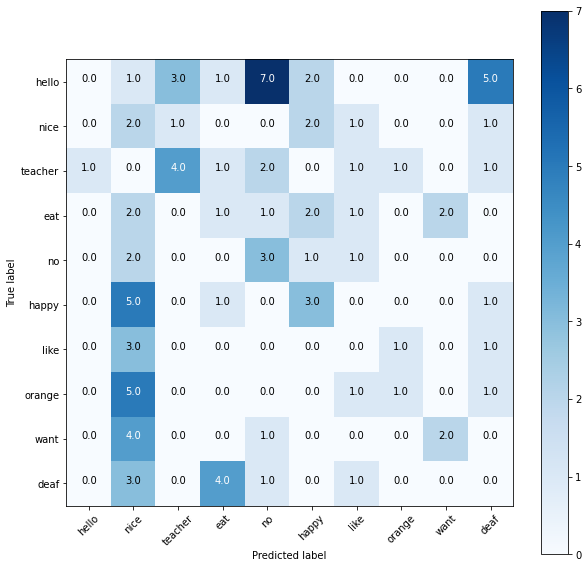

In [ ]:
calculateTestAcc(trained_model,dataloaders,dataset_sizes)